# 5.Neural Network with Softmax Classification

*Made by David Serrano for his Final Bachelor Thesis*

This file uses the manually labeled detections to classify them automatically using Transfer Learning and Fine Tunning.

## 5.1. Environment Preparation

In [1]:
# Useful general imports
from google.colab import drive 

In [2]:
# mount the google drive folder to access to all the files in there
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
# Add the folder called utils that has all the custom modules in .py files
import sys
sys.path.append('/content/drive/MyDrive/TFG/utils')

In [4]:
from paths import PROJECT_ROOT, HDF5_FOLDER, JSON_FOLDER, USABLE_SEQUENCES, MAX_SQUARE_LEN

## 5.2. Pretrained Model

In the following block the ResNet50 pretrained model is loaded. The layers before the main stages and the first three stages of the model are freezed. Then the last fully connected layer is substituted by two linear layers and a ReLU.

In [5]:
import torch
from torchvision.models import resnet50
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# Load the pretrained ResNet50 model
pretrained_model = resnet50(pretrained=True)

# ResNet Block Structure:
# 1. Conv2d
# 2. BatchNorm2d
# 3. ReLU
# 4. MaxPool2d
# 5. Sequential bottleneck
# 6. Sequential bottleneck
# 7. Sequential bottleneck
# 8. Sequential bottleneck
# 9. AdaptativeAvgPool2d
# 10. Linear Layer

# So, if we want to fine-tune from the last Sequential bottleneck until the end
# we have to freeze the first 7 blocks

count = 0
for child in pretrained_model.children():
    if count < 7:
        for param in child.parameters():
            param.requires_grad = False
    count = count + 1

# Create a new FC layer
num_ftrs = pretrained_model.fc.in_features
pretrained_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 128),
    nn.ReLU(),
    nn.Linear(128, 3)
)

pretrained_model = pretrained_model.to(device)

# weights = [1/873, 1/41, 1/37]
# class_weights = torch.FloatTensor(weights).cuda()
# criterion = nn.CrossEntropyLoss(weight=class_weights)

criterion = nn.CrossEntropyLoss()

optimizer_ft = optim.SGD(pretrained_model.parameters(), lr=0.001, momentum=0.9)

exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

pretrained_model

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In the following block, both dataloaders are obtained and grouped in the same dictionary

In [6]:
from dataStructures import splitDataset, balanceDataset, getDataLoaders
from dataPrep import hdf5Initializer

loaders = hdf5Initializer(USABLE_SEQUENCES)

train_detections, train_labels, validation_detections, validation_labels = splitDataset(USABLE_SEQUENCES,
                                                                                        trainPercentage=0.8)
train_detections, train_labels = balanceDataset(train_detections, train_labels, shuffle=True)

train_dataloader, validation_dataloader = getDataLoaders(loaders,
                                                         train_detections,
                                                         train_labels,
                                                         validation_detections,
                                                         validation_labels,
                                                         train_bs=7,
                                                         val_bs=12,
                                                         dataAug='Y',
                                                         pixRange=0,
                                                         degRange=5)

dataloaders = {'train': train_dataloader, 'val': validation_dataloader}

Splitting the dataset into 2 sets of 0.8/0.2
Balancing the train dataset...
Creating the DataLoaders...


## 5.3. Train the Model

In the following block, a class **AverageMeter** is defined to store and measure the cumulative and average accuracy and loss.

In [7]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val
        self.count += n
        self.avg = self.sum / self.count

In the following block, a function which is capable of training the model is defined.

The function iterates both DataLoaders as many times as the number of epochs passed as a parameter. In each iteration goes through all the training and validation Dataset. In each batch we have:

*   data: *size([batch_size, n, 3, MAX_SQUARE_LEN, MAX_SQUARE_LEN)])*
*   labels: *size([batch_size])*

So the first step of the function is to transform the data into a tensor of: 

*size([**batch_size x n**, 3, MAX_SQUARE_LEN, MAX_SQUARE_LEN)])*

After that all the images are passed through the model. The output goes to a Softmax layer to transform the logits into percentatges. The *n* percentatges of each track are then averaged since we are interested in labeling the track not the individual frames.

Using a loss function and the gradient comparing between the predictions and the ground truth labels the weigths of the model are updated.

The funciton returns the model and the confusion matrix which have achieved the best accuracy in the validation set and 4 lists of both training and validation accuracies and losses.

In [8]:
import copy
import torch
from tqdm.notebook import tqdm as tqdm
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import f1_score
import time
import numpy as np


def train_model(model, dataloaders, criterion, optimizer, scheduler, num_epochs=10):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())

    # Metrics to know which epoch is better trained
    best_f1 = 0.0
    best_preds = []
    best_labels = []

    # More metrics to later on be able to plot the acc, loss and confusion matrix
    train_accuracies, train_losses, val_accuracies, val_losses = [], [], [], []
    cm = np.zeros((3, 3), dtype=int)

    train_accuracy = AverageMeter()
    train_loss = AverageMeter()
    val_accuracy = AverageMeter()
    val_loss = AverageMeter()

    for epoch in range(num_epochs):
        print('Epoch {}/{} '.format(epoch + 1, num_epochs))
        print('-' * 10)
        
        cm_epoch = np.zeros((3, 3), dtype=int)

        # Each epoch has a training and validation phase
        for phase in ['train','val']:

            # Epoch time
            epoch_time = time.time()

            # Reset the metrics (loss and accuracy) t the beggining f each epoch
            train_accuracy.reset()
            train_loss.reset()
            val_loss.reset()
            val_accuracy.reset()

            # Boolean to know when it is the first iteration
            first_it=True

            if phase == 'train':
                # Set model to training mode
                model.train()
            else:
                # Set model to evaluate mode
                model.eval()

            # For printing the progress bar
            loop = tqdm(dataloaders[phase], unit=" batches", leave=False)

            # To store all the the validation predictions and labels to later on
            # calculate precision, recall and f1 with sklearn for the best epoch
            val_labels = []
            val_preds = []
            
            # Iterate over data.
            for inputs, labels in loop:
                
                # Create tqdm and get the batch size
                if phase == 'train':
                    loop.set_description('[TRAIN] Epoch {}/{}'.format(epoch + 1, num_epochs))
                    if first_it:
                        train_batch_size = inputs.size(0)
                        first_it=False

                else:
                    loop.set_description('[VAL] Epoch {}/{}'.format(epoch + 1, num_epochs))
                    if first_it:
                        val_batch_size = inputs.size(0)
                        first_it=False

                # Change the inputs size from
                # torch.Size([batch_size, n, 3, 224, 224]) to
                # torch.Size([batch_size * n, 3, 224, 224])
                batch_size = inputs.size(0)
                n = inputs.size(1)
                num_classes = 3

                inputs = inputs.view(-1, *inputs.shape[2:])
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs) # torch.Size([batch_size * n, 3])
                    preds = torch.nn.functional.softmax(outputs, dim=1)

                    # Average the track outputs to have a track prediciton
                    outputs_trackavg = torch.zeros(batch_size, num_classes)
                    percentage_trackavg = torch.zeros(batch_size, num_classes)

                    for batch in range(batch_size): # num_batches
                        for c in range(num_classes): # num_classes
                            outputs_trackavg[batch, c] = outputs[n * batch:(n * batch) + 5, c].sum()/5
                            percentage_trackavg[batch, c] = preds[n * batch:(n * batch) + 5, c].sum()/5
                    
                    preds_trackavg = torch.argmax(percentage_trackavg, dim=1)
                    # _, preds = torch.max(outputs, 1)
                    outputs_trackavg = outputs_trackavg.to(device)
                    preds_trackavg = preds_trackavg.to(device)
                    loss = criterion(outputs_trackavg, labels)

                    # Calculate the metrics
                    k = [True for i in range(len(labels)) if labels[i] == preds_trackavg[i]]
                    acc = len(k)

                    # Update the metrics
                    if phase == 'train':
                        train_accuracy.update(acc, n=len(labels))
                        train_loss.update(loss.item(), n=len(labels))
                    else:
                        for l, p in zip(labels, preds_trackavg):
                            val_labels.append(l.cpu().numpy())
                            val_preds.append(p.cpu().numpy())

                        val_accuracy.update(acc, n=len(labels))
                        val_loss.update(loss.item(), n=len(labels))


                    if phase == 'val':
                        cm_epoch = cm_epoch + confusion_matrix(labels.cpu(),
                                                    preds_trackavg.cpu(),
                                                    labels=[0, 1, 2])
                        
                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                if phase == 'train':
                    loop.set_postfix(loss=train_loss.avg, accuracy=train_accuracy.avg)
                else:
                    loop.set_postfix(loss=val_loss.avg, accuracy=val_accuracy.avg)

            if phase == 'train':
                scheduler.step()

            epoch_elapsed = time.time() - epoch_time

            if phase == 'train':
                train_losses.append(train_loss.avg)
                train_accuracies.append(train_accuracy.avg)
                print('[TRAINING]')
                print('{} batches with batch size {} tracks in {:.0f}m {:.0f}s'.format(len(dataloaders[phase]),
                                                                                train_batch_size,
                                                                                epoch_elapsed // 60,
                                                                                epoch_elapsed % 60
                                                                                ))
                print('Loss: {:.4f} Acc: {:.4f}\n'.format(
                    train_loss.avg, train_accuracy.avg))

            else:
                val_losses.append(val_loss.avg)
                val_accuracies.append(val_accuracy.avg)
                
                f1 = f1_score(val_labels, val_preds, labels=[0, 1, 2],
                              average='macro', zero_division=0)
                print('[VALIDATION]')
                print('{} batches with batch size {} tracks in {:.0f}m {:.0f}s'.format(len(dataloaders[phase]),
                                                                                val_batch_size,
                                                                                epoch_elapsed // 60,
                                                                                epoch_elapsed % 60
                                                                                ))
                print('Loss: {:.4f} Acc: {:.4f} F1-macro: {:.4f}\n'.format(
                    val_loss.avg, val_accuracy.avg, f1))

            # deep copy the model
            if phase == 'val' and f1 > best_f1:
                best_f1 = f1
                best_model_wts = copy.deepcopy(model.state_dict())
                cm = cm_epoch
                best_preds = val_preds
                best_labels = val_labels
                

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s\n'.format(
        time_elapsed // 60, time_elapsed % 60))
    
    print(classification_report(best_labels, best_preds, zero_division=0))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, train_accuracies, train_losses, val_accuracies, val_losses, cm

Train the model for 10 epochs.

In [9]:
model, train_accuracies, train_losses, val_accuracies, val_losses, confusion_matrix = train_model(
    pretrained_model,
    dataloaders,
    criterion,
    optimizer_ft,
    exp_lr_scheduler,
    num_epochs=5)

Epoch 1/5 
----------


[TRAINING]
296 batches with batch size 7 tracks in 65m 26s
Loss: 0.1080 Acc: 0.6660



[VALIDATION]
16 batches with batch size 12 tracks in 4m 48s
Loss: 0.0316 Acc: 0.9115 F1-macro: 0.6552


Epoch 2/5 
----------


[TRAINING]
296 batches with batch size 7 tracks in 63m 50s
Loss: 0.0265 Acc: 0.9371



[VALIDATION]
16 batches with batch size 12 tracks in 4m 45s
Loss: 0.0209 Acc: 0.9271 F1-macro: 0.6458


Epoch 3/5 
----------


[TRAINING]
296 batches with batch size 7 tracks in 64m 34s
Loss: 0.0087 Acc: 0.9831



[VALIDATION]
16 batches with batch size 12 tracks in 4m 42s
Loss: 0.0283 Acc: 0.9010 F1-macro: 0.4943


Epoch 4/5 
----------


[TRAINING]
296 batches with batch size 7 tracks in 64m 44s
Loss: 0.0065 Acc: 0.9869



[VALIDATION]
16 batches with batch size 12 tracks in 4m 42s
Loss: 0.0244 Acc: 0.9323 F1-macro: 0.6237


Epoch 5/5 
----------


[TRAINING]
296 batches with batch size 7 tracks in 64m 26s
Loss: 0.0056 Acc: 0.9879



[VALIDATION]
16 batches with batch size 12 tracks in 4m 44s
Loss: 0.0274 Acc: 0.9062 F1-macro: 0.4928


Training complete in 346m 41s

              precision    recall  f1-score   support

           0       0.96      0.94      0.95       175
           1       0.47      0.78      0.58         9
           2       0.50      0.38      0.43         8

    accuracy                           0.91       192
   macro avg       0.64      0.70      0.66       192
weighted avg       0.92      0.91      0.91       192



## 5.4. Results

In the next block, 2 functions to represent the accuracies and the losses are defined

In [10]:
import matplotlib.pyplot as plt

def plotAccs(train_accuracies, val_accuracies):
    """
    Function which is capable to plot both train and validation accuracies in
    the same graph
    :param train_accuracies: train accuracies
    :param val_accuracies: validation accuracies
    """    
    epochs = range(len(train_accuracies))

    plt.plot(epochs, train_accuracies, 'b', label='Training acc')
    plt.plot(epochs, val_accuracies, 'r', label='Validation acc')
    plt.title('Train/Val Epoch Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.figure()

def plotLosses(train_losses, val_losses):
    """
    Function which is capable to plot both train and validation losses in
    the same graph
    :param train_losses: train accuracies
    :param val_losses: validation losses
    """ 
    epochs = range(len(train_losses))

    plt.plot(epochs, train_losses, 'b', label='Training loss')
    plt.plot(epochs, val_losses, 'r', label='Validation loss')
    plt.title('Train/Val Epoch Loss')
    plt.xlabel('Epochs')
    plt.legend()

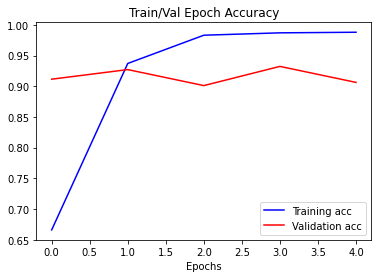

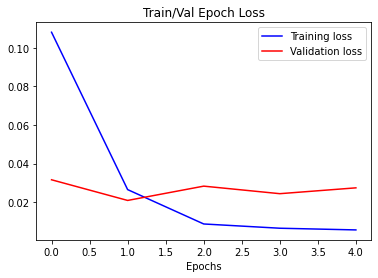

In [11]:
plotAccs(train_accuracies, val_accuracies)
plotLosses(train_losses, val_losses)

In the following block, it is defined a function which is capable of plotting the confusion matrix

In [12]:
import numpy as np
import matplotlib.pyplot as plt
import itertools


def plot_confusion_matrix(cm, classes,
                          normalize=True,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`
    :param cm: confusion matrix
    :param classes: List of all the labels
    :param noramlize: boolen (if True nornalized if False cumulative)
    :param title: string of the plot title
    :param cmap: colormap
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

Normalized confusion matrix
[[0.94285714 0.04       0.01714286]
 [0.22222222 0.77777778 0.        ]
 [0.5        0.125      0.375     ]]


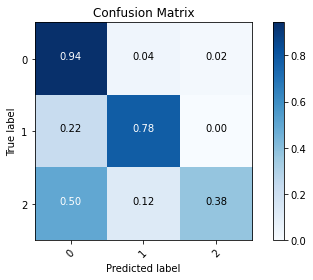

In [13]:
import numpy as np
import matplotlib.pyplot as plt

#np.set_printoptions(precision=2)
#plt.figure()
plot_confusion_matrix(cm=confusion_matrix,
                      classes=[0, 1, 2],
                      normalize=True,
                      title='Confusion Matrix')

## 5.5. Save the Model


Save the model. The name of the model is the model used, the number of epochs and the best validation accuracy

In [14]:
import torch
best_acc = round(max(val_accuracies),4)
num_epochs = len(val_accuracies)
modelName = 'ResNet50_epoch' + str(num_epochs) + 'TEMPORAL' + '.pt'
modelPath = PROJECT_ROOT + '/models/' + modelName
torch.save(model.state_dict(), modelPath)
print('Model save trained on {} epochs with accuracy of {}'.format(num_epochs,
                                                                   best_acc))

Model save trained on 5 epochs with accuracy of 0.9323
